# Recognition of characters in an image

## Context
To extract English characters from an image (usually taken with a camera in mobile phone for the purpose of word search.

## Goal
Based on a image with English characters, recognise the English characters. For the inital phase, achieve an accuracy of 50%. The baseline accuracy is set at 7.2%.

## Dataset reference
The Chars74k image dataset - Character Recognition in Natural Images,
URL: http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/

T. E. de Campos, B. R. Babu and M. Varma. Character recognition in natural images. In Proceedings of the International Conference on Computer Vision Theory and Applications (VISAPP), Lisbon, Portugal, February 2009. 

## Dataset

### Training set
The training set are numeric characters 0 to 9 and English alphabet characters A to Z and a to z, a total of 62 classes that are synthesized from computer fonts.

### Testing set
The testing set are characters that are obtained from natural images.

## Model built
The model built is based on Convolution Neural Networks as the input data are the images with a resolution of 32 X 32.
Note that the number of convolutional layers to be used is based on the resolution of the input image.

## Summary of findings
After running 60 epochs from model training, the accuracy of the model with the trainig set reaches 90% while the performance of the model with the testing set is 36%. 

It's also proven that the increasing the number of epochs in training may not necessary increase the accuracy in the testing set significantly. 

In addition, there are indeed some characters that the model may not recognize easily. This includes "S" with 's' and '0' with 'o'.

## Assumptions/Risks/Limitations
1. Model may not be able to recognize that the characters has been rotated. In addition, including the reconigization of rotated characters can result in model having difficulty to recognize whether the character image is a rotated character or the another character (eg. Rotated 'E' and 'm')
2. Characters that are used in the training set are mostly based on font of Serif and Sans-Serif and Monospace family, as words in cursive are usually joined together which is difficult to break apart into individual characters.
3. Risk of overfitting is seen from the result, even though some measures have been taken to reduce overfitting, such as using lower resolution images and using Dropouts in Dense layers.

In [2]:
import os
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Import cv2 to read and pre-process the image
import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report

# Include TensorFlow library as it is used as the backend to train the model.
import tensorflow as tf

# Keras is used to design the neural network in the coding process.
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import History

/Users/yingkh/anaconda2/envs/tensorflow_1_8/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
K.set_image_data_format('channels_last')

img_rows = 32
img_cols = 32
# Colour is not required in recognizing the character.
num_channel = 1 # greyscale

## Reading and pre-processing of datasets.
The pre-processed datasets are saved into pickle file for the purpose of backing up the datasets.

In [4]:
# Read and resize the image to resolution of 32 X 32.

def read_img(filePath):
    input_img = cv2.imread(filePath)
    bw_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    input_img_resize = cv2.resize(bw_img, (img_rows, img_cols))
    #kernel = np.ones((1, 1), np.uint8)
    #img = cv2.dilate(input_img_resize, kernel, iterations=1)
    #img = cv2.erode(img, kernel, iterations=1)
    return input_img_resize

In [5]:
# Read and pre-process the test images.
def read_test_img(filePath):
    input_img = cv2.imread(filePath)
    bw_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    maxSize = max(bw_img.shape[0], bw_img.shape[1])
    
    img_Width = int(math.floor(img_rows*bw_img.shape[0]/maxSize))
    img_Height = int(math.floor(img_cols*bw_img.shape[1]/maxSize))
    
    dRows = (img_rows - img_Width)/2
    dCols = (img_cols - img_Height)/2
    
    img_resized = cv2.resize(bw_img, (img_Height, img_Width))
    
    imageResized = np.zeros((img_rows, img_cols))
    imageResized[dRows:dRows + img_Width, dCols:dCols + img_Height] = img_resized
    
    background_color = np.median(np.append(imageResized[dRows,:],
                                      (imageResized[dRows + img_Width - 1,:],
                                      imageResized[:,dCols],
                                      imageResized[:,dCols + img_Height - 1])))
    
    if(dRows > 0):
        imageResized[0:dRows,:].fill(background_color)
        imageResized[dRows + img_Width:,:].fill(background_color)
    
    if(dCols > 0):
        imageResized[:,0:dCols].fill(background_color)
        imageResized[:,dCols + img_Height:].fill(background_color)
    
    return imageResized.tolist()

In [15]:
charSet = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

In [6]:
char_img_dict = []

# Load data set
for charClass in range(1, 63):
    datapath = './dataset_selected/Sample{:03d}/'.format(charClass)
    dirs = os.listdir(datapath)
    img_list = []
    print ("Reading: " + datapath)
    for img in dirs:
        input_img = read_img(datapath + img)
        img_list.append(input_img)
    img_data = np.array(img_list)
    img_data = img_data.astype('float32')  
    img_data /= 255
    print(img_data.shape)
    img_data = np.expand_dims(img_data, axis = 4)
    print(img_data.shape)
    char_img_dict += [{'label': charSet[charClass - 1], 'labelcode': charClass - 1, 'image': img} for img in img_data]

Reading: ./dataset_selected/Sample001/
(963, 32, 32)
(963, 32, 32, 1)
Reading: ./dataset_selected/Sample002/


/Users/yingkh/anaconda2/envs/tensorflow_1_8/lib/python2.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


(963, 32, 32)
(963, 32, 32, 1)
Reading: ./dataset_selected/Sample003/
(963, 32, 32)
(963, 32, 32, 1)
Reading: ./dataset_selected/Sample004/
(963, 32, 32)
(963, 32, 32, 1)
Reading: ./dataset_selected/Sample005/
(963, 32, 32)
(963, 32, 32, 1)
Reading: ./dataset_selected/Sample006/
(963, 32, 32)
(963, 32, 32, 1)
Reading: ./dataset_selected/Sample007/
(963, 32, 32)
(963, 32, 32, 1)
Reading: ./dataset_selected/Sample008/
(963, 32, 32)
(963, 32, 32, 1)
Reading: ./dataset_selected/Sample009/
(963, 32, 32)
(963, 32, 32, 1)
Reading: ./dataset_selected/Sample010/
(963, 32, 32)
(963, 32, 32, 1)
Reading: ./dataset_selected/Sample011/
(963, 32, 32)
(963, 32, 32, 1)
Reading: ./dataset_selected/Sample012/
(963, 32, 32)
(963, 32, 32, 1)
Reading: ./dataset_selected/Sample013/
(963, 32, 32)
(963, 32, 32, 1)
Reading: ./dataset_selected/Sample014/
(963, 32, 32)
(963, 32, 32, 1)
Reading: ./dataset_selected/Sample015/
(963, 32, 32)
(963, 32, 32, 1)
Reading: ./dataset_selected/Sample016/
(963, 32, 32)
(963, 

In [7]:
# Load test set

char_img_test = []

for charClass in range(1, 63):
    datapath = './dataset_test/Sample{:03d}/'.format(charClass)
    dirs = os.listdir(datapath)
    img_list = []
    print ("Reading: " + datapath)
    for img in dirs:
        if ".png" in img:
            input_img = read_test_img(datapath + img)
            img_list.append(input_img)
    img_data = np.array(img_list)
    img_data = img_data.astype('float32')  
    img_data /= 255
    print(img_data.shape)
    img_data = np.expand_dims(img_data, axis = 4)
    print(img_data.shape)
    char_img_test += [{'label': charSet[charClass - 1], 'labelcode': charClass - 1, 'image': img} for img in img_data]

Reading: ./dataset_test/Sample001/
(105, 32, 32)
(105, 32, 32, 1)
Reading: ./dataset_test/Sample002/


/Users/yingkh/anaconda2/envs/tensorflow_1_8/lib/python2.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


(80, 32, 32)
(80, 32, 32, 1)
Reading: ./dataset_test/Sample003/
(70, 32, 32)
(70, 32, 32, 1)
Reading: ./dataset_test/Sample004/
(50, 32, 32)
(50, 32, 32, 1)
Reading: ./dataset_test/Sample005/
(47, 32, 32)
(47, 32, 32, 1)
Reading: ./dataset_test/Sample006/
(64, 32, 32)
(64, 32, 32, 1)
Reading: ./dataset_test/Sample007/
(64, 32, 32)
(64, 32, 32, 1)
Reading: ./dataset_test/Sample008/
(48, 32, 32)
(48, 32, 32, 1)
Reading: ./dataset_test/Sample009/
(32, 32, 32)
(32, 32, 32, 1)
Reading: ./dataset_test/Sample010/
(34, 32, 32)
(34, 32, 32, 1)
Reading: ./dataset_test/Sample011/
(558, 32, 32)
(558, 32, 32, 1)
Reading: ./dataset_test/Sample012/
(116, 32, 32)
(116, 32, 32, 1)
Reading: ./dataset_test/Sample013/
(215, 32, 32)
(215, 32, 32, 1)
Reading: ./dataset_test/Sample014/
(191, 32, 32)
(191, 32, 32, 1)
Reading: ./dataset_test/Sample015/
(445, 32, 32)
(445, 32, 32, 1)
Reading: ./dataset_test/Sample016/
(79, 32, 32)
(79, 32, 32, 1)
Reading: ./dataset_test/Sample017/
(143, 32, 32)
(143, 32, 32, 1)

In [8]:
X = np.array([row['image'] for row in char_img_dict])
X_test = np.array([row['image'] for row in char_img_test])

y_raw = [row['labelcode'] for row in char_img_dict]
y_test_raw = [row['labelcode'] for row in char_img_test]

# convert class labels to on-hot encoding
y = np_utils.to_categorical(y_raw, len(charSet))
y_test = np_utils.to_categorical(y_test_raw, len(charSet))

In [8]:
pickle_x_train = './dataset_pickle/x_train.pickle'
pickle_y_train = './dataset_pickle/y_train.pickle'
pickle_x_test = './dataset_pickle/x_test.pickle'
pickle_y_test = './dataset_pickle/y_test.pickle'

In [12]:
# Save dataset into pickle file 
with open(pickle_x_train, 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(pickle_y_train, 'wb') as handle:
    pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(pickle_x_test, 'wb') as handle:
    pickle.dump(X_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(pickle_y_test, 'wb') as handle:
    pickle.dump(y_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
# Load dataset from pickle files
with open(pickle_x_train, 'rb') as handle:
    X = pickle.load(handle)
    
with open(pickle_y_train, 'rb') as handle:
    y = pickle.load(handle)

with open(pickle_x_test, 'rb') as handle:
    X_test = pickle.load(handle)

with open(pickle_y_test, 'rb') as handle:
    y_test = pickle.load(handle)

## Running the model using Convolution Neural Network

In [6]:
def get_cnn_model():
    model = Sequential()

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(img_rows, img_cols, 1)))
    
    # Conv Layer
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Conv Layer 
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten
    model.add(Flatten())
    
    # Dense Layer
    model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    
    # Dense Layer
    model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    
    # Softmax
    model.add(Dense(len(charSet), activation='softmax', kernel_initializer='he_normal'))
    return model

In [9]:
# Set cnn model. 
model = get_cnn_model()

history = History()

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit(X, y, epochs=30, batch_size = 128, verbose=1, validation_data=(X_test, y_test), callbacks=[history])

sgd_optimizer = SGD(nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd_optimizer, metrics=['accuracy'])
hist_result = model.fit(X, y, epochs=30, batch_size = 128, verbose=1, validation_data=(X_test, y_test), callbacks=[history])

## Export model immediately after fitting.
## Exported model can be deployed into production.
modelFilePath = './trained_model/model_1.h5'
model.save(modelFilePath)

Train on 59706 samples, validate on 7700 samples
Epoch 1/30
59706/59706 [==============================] - 330s 6ms/step - loss: 3.2053 - acc: 0.2019 - val_loss: 3.7838 - val_acc: 0.1955
Epoch 2/30
59706/59706 [==============================] - 332s 6ms/step - loss: 1.4217 - acc: 0.6037 - val_loss: 3.5985 - val_acc: 0.2268
Epoch 3/30
59706/59706 [==============================] - 349s 6ms/step - loss: 0.9991 - acc: 0.7094 - val_loss: 3.3971 - val_acc: 0.2531
Epoch 4/30
59706/59706 [==============================] - 356s 6ms/step - loss: 0.8344 - acc: 0.7480 - val_loss: 3.3331 - val_acc: 0.2523
Epoch 5/30
59706/59706 [==============================] - 357s 6ms/step - loss: 0.7425 - acc: 0.7696 - val_loss: 3.2382 - val_acc: 0.2699
Epoch 6/30
59706/59706 [==============================] - 360s 6ms/step - loss: 0.6747 - acc: 0.7876 - val_loss: 3.1361 - val_acc: 0.2839
Epoch 7/30
59706/59706 [==============================] - 366s 6ms/step - loss: 0.6271 - acc: 0.7973 - val_loss: 3.1462 - v

In [35]:
history_record = history.history

In [41]:
pickle_history = 'history.pickle'

In [42]:
with open(pickle_history, 'wb') as handle:
    pickle.dump(history_record, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(pickle_history, 'rb') as handle:
    history_record = pickle.load(handle)

## Evaluation of the model

In [ ]:
# Results of epoch history for loss and accuracy.
df_epoch_history = pd.DataFrame([
    {'loss': 3.2053, 'acc': 0.2019, 'val_loss': 3.7838, 'val_acc': 0.1955},
    {'loss': 1.4217, 'acc': 0.6037, 'val_loss': 3.5985, 'val_acc': 0.2268},
    {'loss': 0.9991, 'acc': 0.7094, 'val_loss': 3.3971, 'val_acc': 0.2531},
    {'loss': 0.8344, 'acc': 0.7480, 'val_loss': 3.3331, 'val_acc': 0.2523},
    {'loss': 0.7425, 'acc': 0.7696, 'val_loss': 3.2382, 'val_acc': 0.2699},
    {'loss': 0.6747, 'acc': 0.7876, 'val_loss': 3.1361, 'val_acc': 0.2839},
    {'loss': 0.6271, 'acc': 0.7973, 'val_loss': 3.1462, 'val_acc': 0.2770},
    {'loss': 0.5942, 'acc': 0.8047, 'val_loss': 3.0743, 'val_acc': 0.2956},
    {'loss': 0.5624, 'acc': 0.8112, 'val_loss': 3.0234, 'val_acc': 0.3040},
    {'loss': 0.5328, 'acc': 0.8203, 'val_loss': 3.0141, 'val_acc': 0.2979},
    {'loss': 0.5129, 'acc': 0.8242, 'val_loss': 2.9883, 'val_acc': 0.3036},
    {'loss': 0.4950, 'acc': 0.8291, 'val_loss': 2.9659, 'val_acc': 0.3040},
    {'loss': 0.4732, 'acc': 0.8348, 'val_loss': 2.9630, 'val_acc': 0.3047},
    {'loss': 0.4585, 'acc': 0.8377, 'val_loss': 2.9267, 'val_acc': 0.3194},
    {'loss': 0.4460, 'acc': 0.8408, 'val_loss': 2.9410, 'val_acc': 0.3168},
    {'loss': 0.4343, 'acc': 0.8438, 'val_loss': 2.9095, 'val_acc': 0.3192},
    {'loss': 0.4258, 'acc': 0.8468, 'val_loss': 2.9338, 'val_acc': 0.3143},
    {'loss': 0.4111, 'acc': 0.8504, 'val_loss': 2.9059, 'val_acc': 0.3235},
    {'loss': 0.4036, 'acc': 0.8513, 'val_loss': 2.9032, 'val_acc': 0.3165},
    {'loss': 0.3909, 'acc': 0.8546, 'val_loss': 2.9175, 'val_acc': 0.3223},
    {'loss': 0.3899, 'acc': 0.8556, 'val_loss': 2.9288, 'val_acc': 0.3169},
    {'loss': 0.3801, 'acc': 0.8579, 'val_loss': 2.8891, 'val_acc': 0.3223},
    {'loss': 0.3749, 'acc': 0.8595, 'val_loss': 2.9182, 'val_acc': 0.3218},
    {'loss': 0.3664, 'acc': 0.8607, 'val_loss': 2.8748, 'val_acc': 0.3279},
    {'loss': 0.3610, 'acc': 0.8632, 'val_loss': 2.8420, 'val_acc': 0.3332},
    {'loss': 0.3537, 'acc': 0.8631, 'val_loss': 2.8862, 'val_acc': 0.3282},
    {'loss': 0.3475, 'acc': 0.8678, 'val_loss': 2.9041, 'val_acc': 0.3321},
    {'loss': 0.3437, 'acc': 0.8686, 'val_loss': 2.9347, 'val_acc': 0.3243},
    {'loss': 0.3386, 'acc': 0.8688, 'val_loss': 2.9598, 'val_acc': 0.3155},
    {'loss': 0.3308, 'acc': 0.8719, 'val_loss': 2.8888, 'val_acc': 0.3299},
    {'loss': 0.3254, 'acc': 0.8740, 'val_loss': 2.8849, 'val_acc': 0.3325},
    {'loss': 0.3243, 'acc': 0.8739, 'val_loss': 2.8806, 'val_acc': 0.3335},
    {'loss': 0.3170, 'acc': 0.8756, 'val_loss': 2.8863, 'val_acc': 0.3305},
    {'loss': 0.3167, 'acc': 0.8752, 'val_loss': 3.0250, 'val_acc': 0.3075},
    {'loss': 0.3131, 'acc': 0.8750, 'val_loss': 2.9142, 'val_acc': 0.3360},
    {'loss': 0.3110, 'acc': 0.8779, 'val_loss': 2.9564, 'val_acc': 0.3253},
    {'loss': 0.3050, 'acc': 0.8793, 'val_loss': 2.9144, 'val_acc': 0.3331},
    {'loss': 0.3040, 'acc': 0.8786, 'val_loss': 2.9027, 'val_acc': 0.3255},
    {'loss': 0.2993, 'acc': 0.8815, 'val_loss': 2.9038, 'val_acc': 0.3369},
    {'loss': 0.2955, 'acc': 0.8820, 'val_loss': 2.9401, 'val_acc': 0.3248},
    {'loss': 0.2917, 'acc': 0.8839, 'val_loss': 3.0336, 'val_acc': 0.3257},
    {'loss': 0.2905, 'acc': 0.8843, 'val_loss': 2.9685, 'val_acc': 0.3260},
    {'loss': 0.2872, 'acc': 0.8853, 'val_loss': 3.0232, 'val_acc': 0.3287},
    {'loss': 0.2861, 'acc': 0.8848, 'val_loss': 2.9842, 'val_acc': 0.3345},
    {'loss': 0.2790, 'acc': 0.8883, 'val_loss': 3.0060, 'val_acc': 0.3314},
    {'loss': 0.2790, 'acc': 0.8875, 'val_loss': 2.9832, 'val_acc': 0.3386},
    {'loss': 0.2759, 'acc': 0.8886, 'val_loss': 2.9866, 'val_acc': 0.3262},
    {'loss': 0.2744, 'acc': 0.8895, 'val_loss': 3.0608, 'val_acc': 0.3294},
    {'loss': 0.2715, 'acc': 0.8915, 'val_loss': 3.0292, 'val_acc': 0.3301},
    {'loss': 0.2698, 'acc': 0.8913, 'val_loss': 3.0224, 'val_acc': 0.3271},
    {'loss': 0.2662, 'acc': 0.8933, 'val_loss': 3.0660, 'val_acc': 0.3255},
    {'loss': 0.2640, 'acc': 0.8929, 'val_loss': 3.0849, 'val_acc': 0.3312},
    {'loss': 0.2610, 'acc': 0.8949, 'val_loss': 3.0283, 'val_acc': 0.3286},
    {'loss': 0.2619, 'acc': 0.8951, 'val_loss': 3.0171, 'val_acc': 0.3290},
    {'loss': 0.2632, 'acc': 0.8936, 'val_loss': 3.0234, 'val_acc': 0.3339},
    {'loss': 0.2573, 'acc': 0.8951, 'val_loss': 3.0842, 'val_acc': 0.3313},
    {'loss': 0.2539, 'acc': 0.8964, 'val_loss': 3.1043, 'val_acc': 0.3291},
    {'loss': 0.2562, 'acc': 0.8963, 'val_loss': 3.0469, 'val_acc': 0.3284},
    {'loss': 0.2544, 'acc': 0.8967, 'val_loss': 3.1084, 'val_acc': 0.3235},
    {'loss': 0.2515, 'acc': 0.8979, 'val_loss': 3.1054, 'val_acc': 0.3264}
])

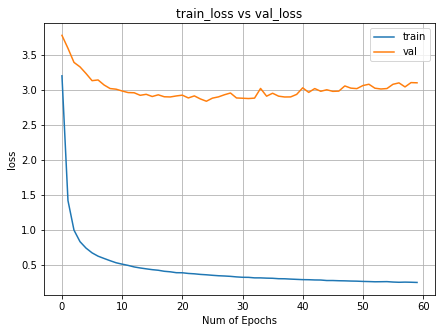

In [5]:
# Plot history training vs validation loss
plt.figure(1, figsize=(7,5))
plt.plot(df_epoch_history['loss'])
plt.plot(df_epoch_history['val_loss'])
plt.xlabel('Num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'], loc='best')
plt.show()

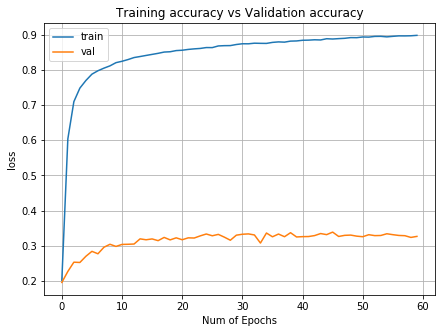

In [6]:
# Plot history training vs validation accuracy
plt.figure(1, figsize=(7,5))
plt.plot(df_epoch_history['acc'])
plt.plot(df_epoch_history['val_acc'])
plt.xlabel('Num of Epochs')
plt.ylabel('loss')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['train','val'], loc='best')
plt.show()

80% accuracy can be achieved in less than 10 epochs and have been steadly increasing to 90% by the 60th epoch. As for the test set, the accuracy of the test set hovers just above 30% after 10 epochs. There is no evidence to prove that incresing the number of epochs will increase the accuracy of the test set.

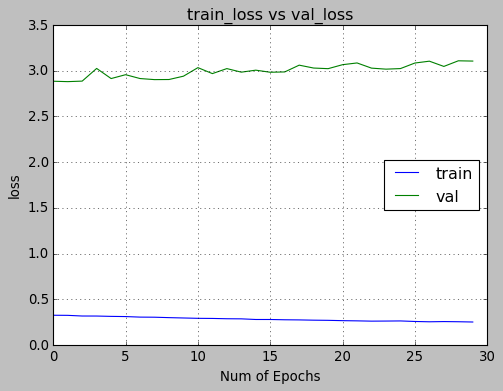

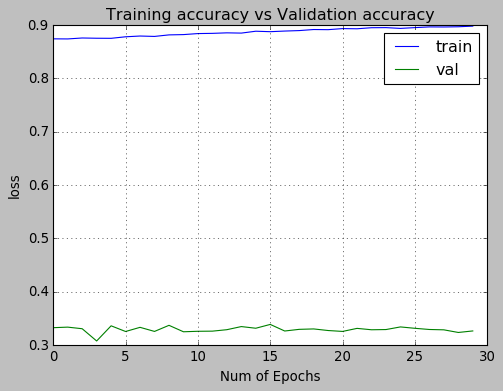

In [40]:
# Look at loss and accuracy in the last 30 epoch of training.

# Range for number of epoch
xc = range(30)

# Plot history training vs validation loss
plt.figure(1, figsize=(7,5))
plt.plot(xc, history_record['loss'])
plt.plot(xc, history_record['val_loss'])
plt.xlabel('Num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'], loc='best')
plt.show()

# Plot history training vs validation accuracy
plt.figure(1, figsize=(7,5))
plt.plot(xc, history_record['acc'])
plt.plot(xc, history_record['val_acc'])
plt.xlabel('Num of Epochs')
plt.ylabel('loss')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['train','val'], loc='best')
plt.show()

In [11]:
# Load model for evaluation
modelFilePath = './trained_model/model_1.h5'
model = load_model(modelFilePath)

In [12]:
# Evaluate model
y_prob = model.predict(X_test) 
y_hat = y_prob.argmax(axis=-1)

In [13]:
y_actual = y_test.argmax(axis=-1)

In [16]:
y_hat_label = [charSet[i] for i in y_hat]
y_actual_label = [charSet[i] for i in y_actual]

In [24]:
# Generate the confusion matrix.
cm = confusion_matrix(y_actual, y_hat, labels=range(62))

Given the number of classes in the confusion, the confusion matrix can be visualized in the form of the heatmap rather than in the form of table to understand the performance of the variable.

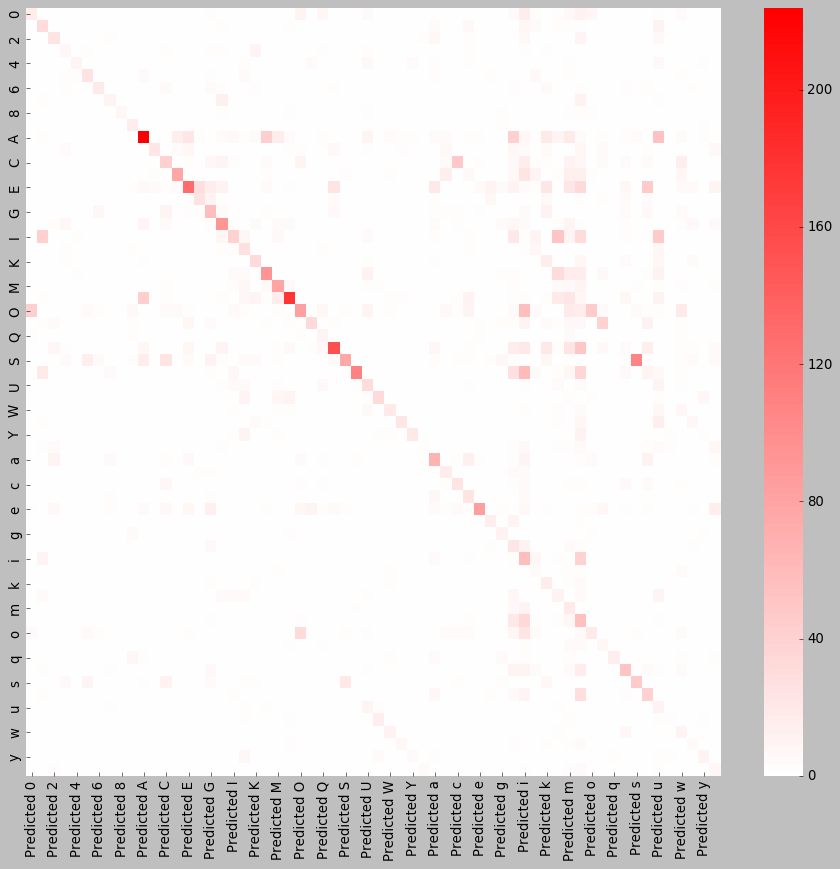

In [49]:
# Generate heatmap based on confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(pd.DataFrame(cm, index=[c for c in charSet], columns=["Predicted " + c for c in charSet]), cmap='bwr', center=0)
plt.show()

The heatmap shows that there are some degree of significance that the model can be confused 'S' with 's', 'o' with '0' and 'O' with 'o'. 

In [1]:
# Base accuracy of the character A
558.0 / 7700 

0.07246753246753247

In [17]:
print(classification_report(y_actual_label, y_hat_label, labels=[c for c in charSet]))

             precision    recall  f1-score   support

          0       0.23      0.15      0.18       105
          1       0.23      0.39      0.29        80
          2       0.33      0.34      0.34        70
          3       0.17      0.16      0.16        50
          4       0.43      0.19      0.26        47
          5       0.36      0.39      0.38        64
          6       0.45      0.30      0.36        64
          7       0.26      0.21      0.23        48
          8       0.80      0.25      0.38        32
          9       0.31      0.50      0.39        34
          A       0.66      0.40      0.50       558
          B       0.79      0.19      0.31       116
          C       0.32      0.19      0.24       215
          D       0.66      0.40      0.50       191
          E       0.61      0.29      0.39       445
          F       0.34      0.32      0.33        79
          G       0.32      0.39      0.35       143
          H       0.49      0.47      0.48   

From the classification report, average precision of close to 50% can be achieved. However, the actual accuracy is less than 50%.